In [51]:
import pandas as pd 
import numpy as np 
import os 
import env 
import prepare

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import unicodedata
import re
import json
from wordcloud import WordCloud


import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords


from bs4 import BeautifulSoup
import requests
import os

# Spam Data

### Load the spam data set.

In [2]:
df = prepare.get_spam_data()
df.head(2)

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...


In [3]:
# reset the index
df = df.set_index('id')
df.head(2)

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


#### Clean Data Set 


In [54]:
#Define function to clean up text data
def clean_text(text, extra_stopwords=['r', 'u']):
    '''
    This function takes in text and optional additional stopwords
    then it stems the text, removes stopwords, and removes special characters
    Returning a block of cleaned text
    '''
    #create the stemmer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #remove stopwords
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    #remove special characters
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    #remove special characters using regex
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    #return the cleaned block of text
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

#### Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [8]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [58]:
# verify 
[clean(word) for word in df.text][:1]

[['go',
  'jurong',
  'point',
  'crazy',
  'available',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'got',
  'amore',
  'wat']]

#### Use the function we just created to clean the text data by label


In [59]:
#clean only ham words
ham_words = clean_text(' '.join(df[df['label'] == 'ham']['text']))

#clean only spam words
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))

#clean all words
all_words = clean_text(' '.join(df['text']))

In [60]:
# Verify 
ham_words[:5]

['go', 'jurong', 'point', 'crazy', 'available']

In [61]:
# Verify 
spam_words[:5]

['free', 'entry', '2', 'wkly', 'comp']

#### Create variables to hold the value counts for each lable data frame 

In [62]:
#count of ham words
ham_counts = pd.Series(ham_words).value_counts()

#count of spam words
spam_counts = pd.Series(spam_words).value_counts()

#count of all words
all_counts = pd.Series(all_words).value_counts()

In [65]:
# verity 
ham_counts.head(10)

im      449
get     314
2       305
ltgt    276
go      273
ok      272
dont    257
come    242
call    241
know    241
Name: count, dtype: int64

In [66]:
# verity 
spam_counts.head(10)

call      359
free      216
2         173
txt       150
ur        144
text      137
mobile    135
4         119
claim     115
stop      113
Name: count, dtype: int64

#### Takeaways:
- See words like claim, free, and call in spam 
- see words like im, get, and ok in ham 

In [67]:
#Combine the value counts into one dataframe
word_freq = pd.concat([ham_counts, spam_counts, all_counts], axis=1)

#take a look
word_freq.head()

,count,count,count
im,449.0,13.0,462
get,314.0,83.0,397
2,305.0,173.0,478
ltgt,276.0,NaN,276
go,273.0,31.0,304


In [11]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
label,,
ham,4825,0.865937
spam,747,0.134063


In [68]:
#Check for nulls
word_freq.isna().sum()

count    1918
count    6087
count       0
dtype: int64

In [69]:
#Rename columns to make more readable
word_freq.columns = ['ham', 'spam', 'all']

#fill null values
word_freq.fillna(0, inplace=True)

#take a look
word_freq.head()

,ham,spam,all
im,449.0,13.0,462
get,314.0,83.0,397
2,305.0,173.0,478
ltgt,276.0,0.0,276
go,273.0,31.0,304


In [70]:
#what datatypes are we working with?
word_freq.dtypes

ham     float64
spam    float64
all       int64
dtype: object

In [71]:
#Recast all columns as integers
word_freq = word_freq.astype('int')

#take a look
word_freq.head()

,ham,spam,all
im,449,13,462
get,314,83,397
2,305,173,478
ltgt,276,0,276
go,273,31,304


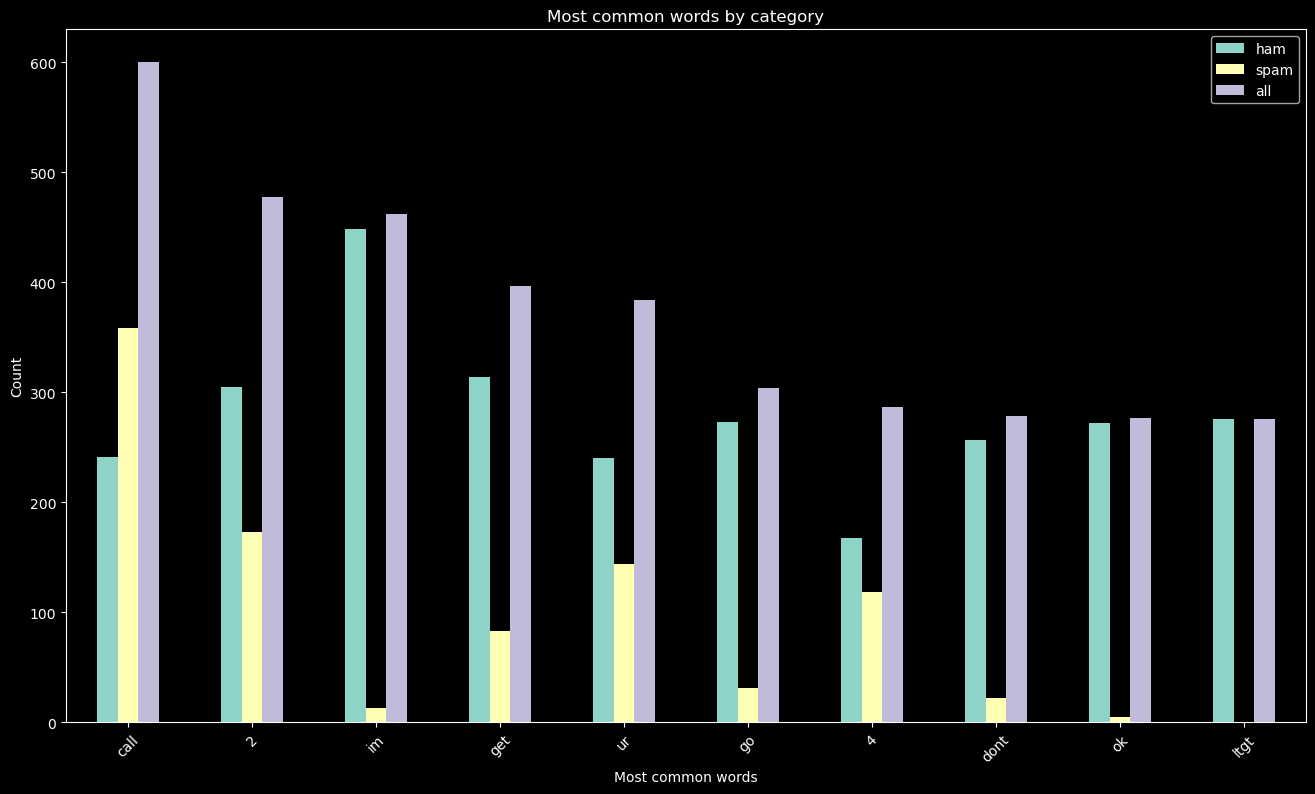

In [72]:
#Plot the most frequent words and color by label
word_freq.sort_values('all', ascending=False).head(10).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

In [73]:
#Calculate percentage of all words by label
word_freq['pct_ham'] = word_freq['ham'] / word_freq['all'] * 100
word_freq['pct_spam'] = word_freq['spam'] / word_freq['all'] * 100
word_freq.head()

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
2,305,173,478,63.807531,36.192469
ltgt,276,0,276,100.000000,0.000000
go,273,31,304,89.802632,10.197368


In [74]:
#Look at the highest percent ham words
word_freq[word_freq['ham'] > 200].sort_values('pct_ham', ascending=False)

,ham,spam,all,pct_ham,pct_spam
ltgt,276,0,276,100.000000,0.000000
ill,236,1,237,99.578059,0.421941
ok,272,5,277,98.194946,1.805054
come,242,5,247,97.975709,2.024291
im,449,13,462,97.186147,2.813853
got,231,7,238,97.058824,2.941176
good,223,12,235,94.893617,5.106383
like,232,13,245,94.693878,5.306122
dont,257,22,279,92.114695,7.885305
time,213,19,232,91.810345,8.189655


In [75]:
#Highest percent spam words
word_freq[word_freq['spam'] > 100].sort_values('pct_spam', ascending=False)

,ham,spam,all,pct_ham,pct_spam
claim,0,115,115,0.000000,100.000000
txt,13,150,163,7.975460,92.024540
mobile,15,135,150,10.000000,90.000000
free,59,216,275,21.454545,78.545455
stop,40,113,153,26.143791,73.856209
reply,43,102,145,29.655172,70.344828
text,77,137,214,35.981308,64.018692
call,241,359,600,40.166667,59.833333
4,168,119,287,58.536585,41.463415
ur,240,144,384,62.500000,37.500000


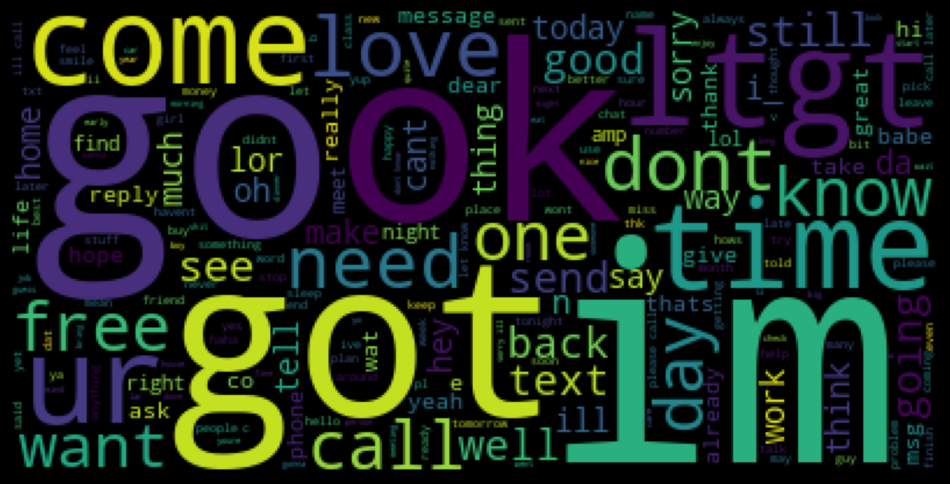

In [76]:
#Word cloud for ALL words
all_cloud = WordCloud().generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [77]:
word_freq.head(10)

,ham,spam,all,pct_ham,pct_spam
im,449,13,462,97.186147,2.813853
get,314,83,397,79.093199,20.906801
2,305,173,478,63.807531,36.192469
ltgt,276,0,276,100.000000,0.000000
go,273,31,304,89.802632,10.197368
ok,272,5,277,98.194946,1.805054
dont,257,22,279,92.114695,7.885305
come,242,5,247,97.975709,2.024291
call,241,359,600,40.166667,59.833333
know,241,26,267,90.262172,9.737828


In [78]:
#Bigrams!
ham_bigrams = pd.Series(nltk.ngrams(ham_words, 2))
ham_bigrams.head()

0          (go, jurong)
1       (jurong, point)
2        (point, crazy)
3    (crazy, available)
4    (available, bugis)
dtype: object

In [79]:
#Retrieve the 10 most frequent bigrams
top_ham_bigrams = ham_bigrams.value_counts().head(10)
top_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(wan, 2)           31
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
Name: count, dtype: int64

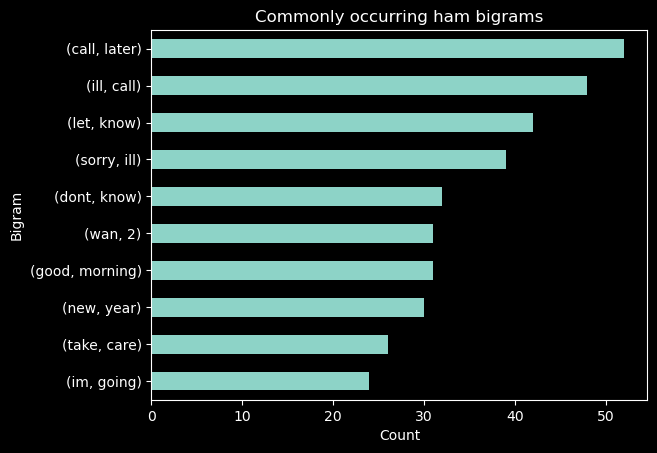

In [80]:
#Plot
top_ham_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Commonly occurring ham bigrams')
plt.show()

In [81]:
#Make spam bigrams
spam_bigrams = pd.Series(nltk.ngrams(spam_words, 2))
spam_bigrams.head()

0    (free, entry)
1       (entry, 2)
2        (2, wkly)
3     (wkly, comp)
4      (comp, win)
dtype: object

In [82]:
#Return the 10 most frequent spam bigrams
top_spam_bigrams = spam_bigrams.value_counts().head(10)
top_spam_bigrams

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
(prize, guaranteed)    22
(await, collection)    19
(every, week)          19
(send, stop)           19
(urgent, mobile)       18
Name: count, dtype: int64

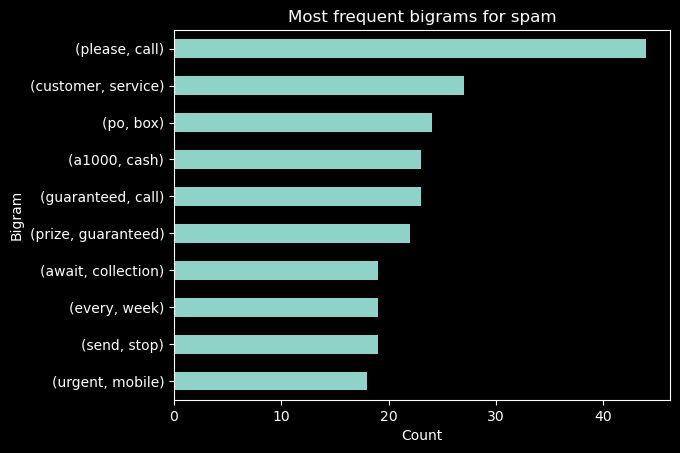

In [83]:
#Plot
top_spam_bigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.title('Most frequent bigrams for spam')
plt.show()


#### Is there any overlap in the bigrams for the spam data and the ham data?


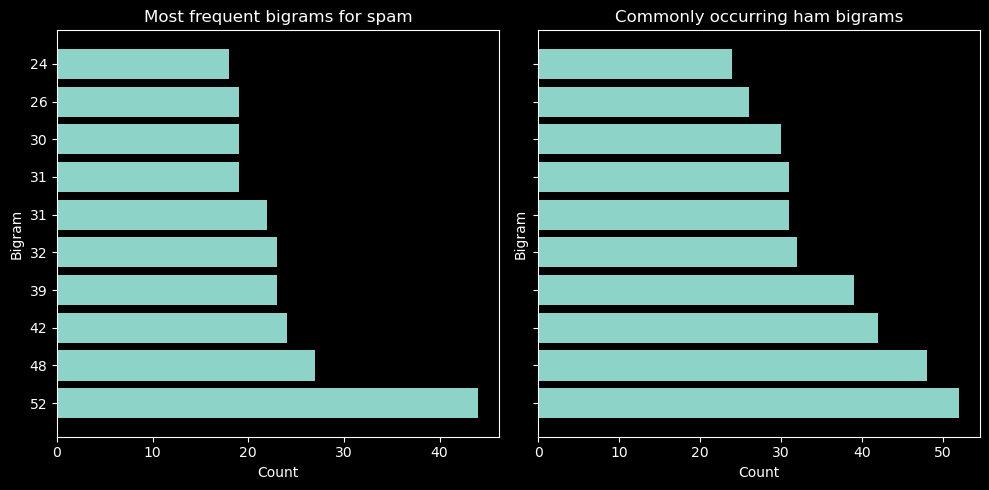

In [89]:
# Convert tuples to strings or bytes
top_spam_bigrams = [str(bigram) for bigram in top_spam_bigrams]
top_ham_bigrams = [str(bigram) for bigram in top_ham_bigrams]

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot top spam bigrams
axes[0].barh(range(len(top_spam_bigrams)), [int(count) for count in top_spam_bigrams])
axes[0].invert_yaxis()
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Bigram')
axes[0].set_yticks(range(len(top_spam_bigrams)))
axes[0].set_yticklabels(top_spam_bigrams)
axes[0].set_title('Most frequent bigrams for spam')

# Plot top ham bigrams
axes[1].barh(range(len(top_ham_bigrams)), [int(count) for count in top_ham_bigrams])
axes[1].invert_yaxis()
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Bigram')
axes[1].set_yticks(range(len(top_ham_bigrams)))
axes[1].set_yticklabels(top_ham_bigrams)
axes[1].set_title('Commonly occurring ham bigrams')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplot
plt.show()

#### Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [91]:
#Trigrams!
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3))
ham_trigrams.head()

0          (go, jurong, point)
1       (jurong, point, crazy)
2    (point, crazy, available)
3    (crazy, available, bugis)
4        (available, bugis, n)
dtype: object

In [93]:
#Return the 10 most frequent spam bigrams
top_ham_trigrams = ham_trigrams.value_counts().head(10)
top_ham_trigrams

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
(pick, phone, right)    12
(phone, right, pls)     12
(right, pls, send)      12
(hi, hi, hi)            11
(x, x, x)                8
Name: count, dtype: int64

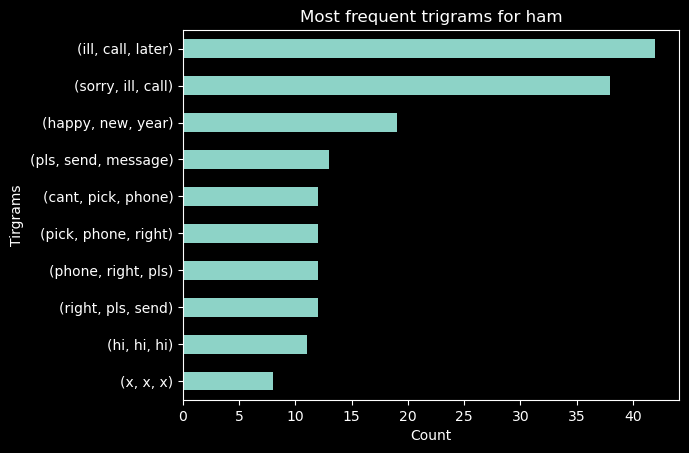

In [96]:
#Plot
top_ham_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Tirgrams')
plt.title('Most frequent trigrams for ham')
plt.show()

In [92]:
#Trigrams!
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3))
spam_trigrams.head()

0     (free, entry, 2)
1     (entry, 2, wkly)
2      (2, wkly, comp)
3    (wkly, comp, win)
4      (comp, win, fa)
dtype: object

In [94]:
#Return the 10 most frequent spam bigrams
top_spam_trigrams = spam_trigrams.value_counts().head(10)
top_spam_trigrams

(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(private, 2003, account)      13
(2003, account, statement)    13
(camcorder, reply, call)      12
(show, 800, unredeemed)       12
(guaranteed, a1000, cash)     12
(tone, 4, ur)                 11
Name: count, dtype: int64

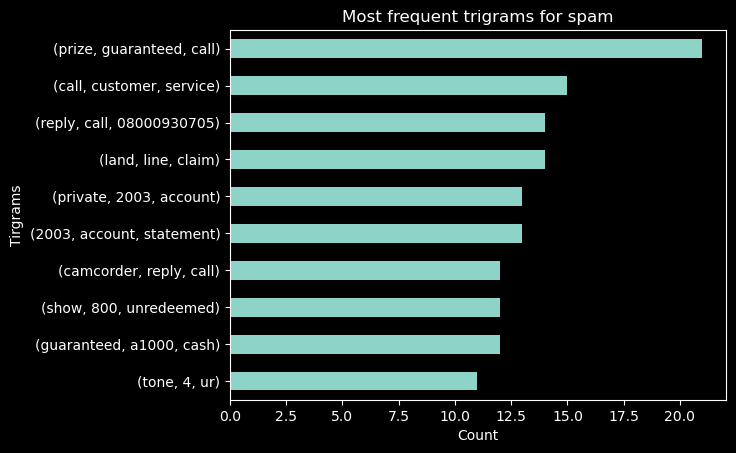

In [97]:
#Plot
top_spam_trigrams.plot.barh().invert_yaxis()
plt.xlabel('Count')
plt.ylabel('Tirgrams')
plt.title('Most frequent trigrams for spam')
plt.show()

### Explore the blog articles using the techniques discussed in the exploration lesson.

In [183]:
base_url = 'https://codeup.edu/blog/'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0"}
codeup_request = requests.get(base_url, headers=headers)
soup = BeautifulSoup(codeup_request.text, 'html.parser')
blog_links = [element['href'] for element in soup.find_all('a', class_='more-link')]

In [184]:
# lets iterate through those blog links an build out a structure
# that will allow me to scrape the contents of that page
all_blogs = []
for link in blog_links:
    # get a response from the link element
    response = requests.get(link, headers={'User-Agent': 'Robinson Rulez lol'})
    #turn the response text into a soup
    soup = BeautifulSoup(response.text, 'html.parser')
    #grab the html element associated with the article body
    title = soup.find('h1', class_='entry-title').text
    #grab the html element associated with the article head
    body = soup.find('div', class_='entry-content').text.strip()
    # toss those two things with labels into a dictionary
    row = {'title': title, 'article': body}
    #add that dictionary to a list of dictionaries
    all_blogs.append(row)
#outside the loop:
# cast the list of dictionaries into a pandas DataFrame
articles = pd.DataFrame(all_blogs)

In [185]:
articles.head(3)

,title,article
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...


### use the clean funtion 

In [186]:
# looking at what articles I have 
articles.title.value_counts()

title
Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa    1
Women in tech: Panelist Spotlight – Magdalena Rahn                                        1
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill                                1
Women in Tech: Panelist Spotlight – Sarah Mellor                                          1
Women in Tech: Panelist Spotlight – Madeleine Capper                                      1
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia                  1
Name: count, dtype: int64

In [187]:
# Changed the regex 
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r"[^a-z0-9'\s]", '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
def basic_clean(paragraph):
    paragraph = paragraph.lower()
    paragraph = re.sub(r"[^a-z0-9'\s]", '', paragraph)
    paragraph = unicodedata.normalize('NFKD', paragraph)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')
    return paragraph

In [188]:
# test the clean fuction to make sure its doing what I want 
articles.article[0]
clean(articles.article[0])[:10]

['may',
 'traditionally',
 'known',
 'asian',
 'american',
 'pacific',
 'islander',
 'aapi',
 'heritage',
 'month']

In [195]:
# I want to use this fuction on all 'Woman for tech' articles 
woman_for_tech = articles[articles.title.str.startswith('W')]

# Change the dtype to string 
woman_for_tech = woman_for_tech.astype({'title': 'string', 'article': 'string'})
woman_for_tech.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    4 non-null      string
 1   article  4 non-null      string
dtypes: string(2)
memory usage: 96.0 bytes


In [192]:
# rename 
black_excellence_in_tech = articles[articles.title.str.startswith('B')]
black_excellence_in_tech = black_excellence_in_tech.astype({'title': 'string', 'article': 'string'})
black_excellence_in_tech.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 5 to 5
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1 non-null      string
 1   article  1 non-null      string
dtypes: string(2)
memory usage: 24.0 bytes


In [202]:
# using list comprehesion 
clean_woman_for_tech = [clean(art) for art in woman_for_tech.article]
all_article_words = [clean(art) for art in articles.article]


In [ ]:
#clean only ham words
ham_words = clean_text(' '.join(woman_for_tech['text']))

#clean only spam words
spam_words = clean_text(' '.join(df[df['label'] == 'spam']['text']))

#clean all words
all_words = clean_text(' '.join(df['text']))

In [201]:
# could not get the black exellence article to work 
# I will try again later 
# clean_black_excellence_in_tech = clean(black_excellence_in_tech.article)


In [200]:
all_article_words[5]

['black',
 'excellence',
 'tech',
 'panelist',
 'spotlight',
 'wilmarie',
 'de',
 'la',
 'cruz',
 'mejia',
 'codeup',
 'hosting',
 'black',
 'excellence',
 'tech',
 'panel',
 'honor',
 'black',
 'history',
 'month',
 'february',
 '22',
 '2023',
 'celebrate',
 'wed',
 'like',
 'spotlight',
 'panelist',
 'leading',
 'discussion',
 'learn',
 'bit',
 'respective',
 'experience',
 'black',
 'leader',
 'tech',
 'industry',
 'meet',
 'wilmarie',
 'wilmarie',
 'de',
 'la',
 'cruz',
 'mejia',
 'current',
 'codeup',
 'student',
 'path',
 'becoming',
 'fullstack',
 'web',
 'developer',
 'dallas',
 'tx',
 'campus',
 'wilmarie',
 'veteran',
 'expanding',
 'knowledge',
 'programming',
 'language',
 'technology',
 'journey',
 'codeup',
 'asked',
 'wilmarie',
 'share',
 'experience',
 'codeup',
 'share',
 'able',
 'meet',
 'people',
 'passionate',
 'coding',
 'positive',
 'learning',
 'environment',
 'hope',
 'join',
 'u',
 'february',
 '22nd',
 'sit',
 'insightful',
 'conversation',
 'wilmarie',
 'pa

#### Make a variable to hold all the value counts 

In [204]:
woman_in_tech_counts = pd.Series(clean_woman_for_tech).value_counts()

all_article_counts = pd.Series(all_article_words).value_counts()

In [207]:
woman_in_tech_counts.head(10)

[woman, tech, panelist, spotlight, magdalena, rahn, codeup, hosting, woman, tech, panel, honor, woman, history, month, march, 29th, 2023, celebrate, wed, like, spotlight, panelist, leading, discussion, learn, bit, respective, experience, woman, tech, industry, meet, magdalena, magdalena, rahn, current, codeup, student, data, science, cohort, san, antonio, texas, professional, background, crosscultural, communication, international, business, development, wine, industry, journalism, serving, u, navy, decided, complement, professional, skill, set, attending, data, science, program, codeup, set, graduate, march, 2023, magdalena, fluent, french, bulgarian, chinesemandarin, spanish, italian, asked, magdalena, codeup, impacted, career, replied, codeup, provided, solid, foundation, analytical, process, programming, data, science, method, encouragement, supportive, instructor, wonderful, classmate, ...]    1
[woman, tech, panelist, spotlight, rachel, robbinsmayhill, codeup, hosting, woman, tec

In [208]:
all_article_counts.head(10)

[may, traditionally, known, asian, american, pacific, islander, aapi, heritage, month, month, celebrate, history, contribution, made, possible, aapi, friend, family, community, also, examine, level, support, seek, opportunity, better, understand, aapi, community, effort, address, real, concern, experience, sat, arbeena, thapa, one, codeups, financial, aid, enrollment, manager, arbeena, identifies, nepali, american, desi, arbeenas, parent, immigrated, texas, 1988, better, employment, educational, opportunity, arbeenas, older, sister, five, made, move, u, arbeena, born, later, becoming, first, family, u, citizen, codeup, take, effort, inclusivity, seriously, speaking, arbeena, taught, term, aapi, excludes, desiamerican, individual, hence, use, term, asian, pacific, islander, desi, american, apida, rest, conversation, arbeena, went, celebrate, ...]                                                       1
[woman, tech, panelist, spotlight, magdalena, rahn, codeup, hosting, woman, tech, pane